<a href="https://colab.research.google.com/github/velozo27/TCC-Pedro-Velozo-ENG1132/blob/change-how-image-files-are-retrieved/SRCNN_Comentada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports e definição de Constantes

In [1]:
try:
    from google.colab import files
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATASET_ROOT="/content/gdrive/MyDrive/TCC/datasets"
    !pip install patchify
    # wandb to log system metrics: (check CPU and GPU usage while session is runnig)
    !pip install wandb
    import wandb
    wandb.init()
    
    import save_model_helper

except ModuleNotFoundError:
    DATASET_ROOT="./datasets/"
    # coloquei as dependencias em um arquivo separado
    !pip install -r requirements.txt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.io import read_image
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Resize
import pandas as pd
import time
import re
from pathlib import Path
import image_patches
import image_helper
import load_model_helper


DATASET_NAME = "Flickr2K"
# DATASET_NAME = "Set14"

# Mudar aqui se for para treinar salvando os dataframes e epochs no drive
# Se True, não pega nem salva nada no drive
EXPERIMENTAL_MODE = True


# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
# garantir que é cuda
assert device == "cuda"

# https://stackoverflow.com/questions/65734044/kernel-appears-to-have-died-jupyter-notebook-python-matplotlib
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# https://stackoverflow.com/a/74952995
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"


# Criando os patches

(patches já foram criados, não precisa rodar)

In [2]:
%time
# otimizacao: criar patches de treino, validacao e teste de uma vez: (32, 8, 2)
# image_patches.create_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_train", 32)
# image_patches.create_image_patches(f"{DATASET_ROOT}/{DATASET_NAME}", (33, 33, 3), f"{DATASET_ROOT}/{DATASET_NAME}_validation", 8)

CPU times: total: 0 ns
Wall time: 0 ns


# ***SRCNN***

In [3]:
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=9 // 2)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=5 // 2)
        self.conv3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=5 // 2)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


In [4]:
model_test = SRCNN(num_channels=3)

input_1 = torch.randn([3, 33, 33])
print(input_1.shape)

output_1 = model_test(input_1)
print(output_1.shape)

torch.Size([3, 33, 33])
torch.Size([3, 33, 33])


# Loops de **Treino** e **Validação**

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    print(f"Training on {size} samples...")
    print("Batch size:", dataloader.batch_size)
    print("Number of batches:", num_batches)

    train_loss = 0
    for batch, (X, y) in tqdm(enumerate(dataloader), total=len(dataloader)):
        X = X.to(device)
        #print("X", X.shape, X.get_device())
        y = y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss /= num_batches

    # return avg loss
    print(f"Training Error: \n Avg loss: {train_loss:>8f} \n")
    return train_loss

# will also be used for testing (maybe)
def validation_loop(dataloader, model, loss_fn, device="cuda" if torch.cuda.is_available() else "cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    validation_loss = 0

    with torch.no_grad(), tqdm(total=num_batches) as progress_bar:
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            validation_loss += loss_fn(pred, y).item()
            progress_bar.update(1)

    validation_loss /= num_batches

    print(f"Validation Error: \n Avg loss: {validation_loss:>8f} \n")
    return validation_loss


# CustomImageDataset

In [6]:
class CustomImageDataset(Dataset):
    """
    A PyTorch dataset for loading a directory of images.

    Args:
        img_dir (str): The path to the directory containing the images.
        transform (callable, optional): A function/transform that takes in an image and returns a
            transformed version. Default: None.
        target_transform (callable, optional): A function/transform that takes in the target and
            transforms it. Default: None.
    """

    def __init__(self, img_dir: str, patches_per_image = None | int, transform = None, target_transform = None, use_patches = True, device="cuda" if torch.cuda.is_available() else "cpu" ):
        """
        Initializes a new instance of the CustomImageDataset class.

        Args:
            img_dir (str): The path to the directory containing the images.
            transform (callable, optional): A function/transform that takes in an image and returns a
                transformed version. Default: None.
            target_transform (callable, optional): A function/transform that takes in the target and
                transforms it. Default: None.
        """
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.patches_per_image = patches_per_image
        
        self.file_list_tensor = self.create_tensors_from_images()
        self.file_list_tensor.to(device)

    def create_tensors_from_images(self):
      number_of_images = self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

      # creating the empty tensor
      image_tensors = torch.empty((number_of_images, 3, 33, 33))

      current_tensor_index = 0

      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      for patch_path in tqdm(list(os.listdir(all_patches_dir))):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue
          
          image_as_tensor = read_image(f"{self.img_dir}/{image_path}")

          # updating the created tensor
          image_tensors[current_tensor_index] = image_as_tensor.float() / 255

          current_tensor_index += 1
                    
      return image_tensors


    def __len__(self) -> int:
        """
        Returns the number of images in the dataset.

        Returns:
            The number of images in the dataset.
        """
        return self._get_number_of_images_in_folder(f"{self.img_dir}/patches")

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Returns the image at the specified index in the dataset.

        Args:
            idx (int): The index of the image to return.

        Returns:
            A tuple containing the transformed input image and the transformed target image.
        """
    
        image = self.file_list_tensor[idx]
        image_x = image.detach().clone()
        image_y = image.detach().clone()

        if self.transform:
            image_x = self.transform(image_x)
        if self.target_transform:
            image_y = self.target_transform(image_y)

        return image_x, image_y

    def _get_number_of_images_in_folder(self, dir: str):
      """
      Gets the total number of all the patches
      """
      all_patches_dir = f"{self.img_dir}/patches"
      if not os.path.exists(all_patches_dir) or not os.path.isdir(all_patches_dir):
          return list(os.listdir(self.img_dir))

      number_of_images = 0
      for patch_path in list(os.listdir(all_patches_dir)):
        one_patch_full_dir = f"{all_patches_dir}/{patch_path}"
        one_path_relative_dir = f"patches/{patch_path}"
        
        patches_list = list(os.listdir(one_patch_full_dir))
        
        for index, patch in enumerate(patches_list):
          image_path = f"{one_path_relative_dir}/{patch}"

          if self._check_if_image_is_not_corrupted(image_path):
            continue

          number_of_images += 1

      return number_of_images

    def _check_if_image_is_not_corrupted(self, image_path: str) -> bool:
      """
      Returns True if the file is corrupted else returns False
      """
      file_size = Path(f"{self.img_dir}/{image_path}").stat().st_size

      if file_size == 0:
        print(f"Error loading image file: {self.img_dir}/{image_path}. Reason: file has size 0")
        return True
      
      return False

# Criando os ***Dataset*'s**

In [7]:
%%time
transform_x = transforms.Compose([
    # downscale by factor of 3 (from 33x33 to 11x11 back to 33x33)
    # resize image to 11x11 and downsample by BICUBIC interpolation
    transforms.Resize((11, 11), interpolation=Image.BICUBIC),
    # resize image to 33x33
    transforms.Resize((33, 33), interpolation=Image.BICUBIC)
    # transforms.CenterCrop((33, 33))
])

transform_y = transforms.Compose([
    ##transforms.Resize((33, 33), interpolation=Image.BICUBIC)
    # transforms.CenterCrop((21, 21))
    # transforms.CenterCrop((25, 25))
    transforms.CenterCrop((33, 33))
])

# Set up the data loaders
train_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_train", transform=transform_x, target_transform=transform_y)
validation_data_set = CustomImageDataset(
    img_dir=f"{DATASET_ROOT}/{DATASET_NAME}_validation", transform=transform_x, target_transform=transform_y)

# # Report split sizes
print('Training set has {} instances'.format(len(train_data_set)))
print('Validation set has {} instances'.format(len(validation_data_set)))

100%|█████████████████████████████████████████████████████████████████████████████| 2650/2650 [00:13<00:00, 189.38it/s]


Training set has 84800 instances
Validation set has 21200 instances
CPU times: total: 15.6 s
Wall time: 1min 28s


In [8]:
%%time

# https://towardsdatascience.com/7-tips-for-squeezing-maximum-performance-from-pytorch-ca4a40951259
pin_memory = True
batch_size = round(0.9*(2**12))

train_dataloader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True, pin_memory=pin_memory) # TODO: aumentar batch_size p/ 2^12
validation_dataloader = DataLoader(validation_data_set, batch_size=batch_size, pin_memory=pin_memory)

CPU times: total: 6.7 s
Wall time: 8.99 s


# Instanciando o modelo

In [9]:
# Instancianting the model
# Atencao: cuidado ao rodar o treino várias vezes sem resetar o modelo!
# model = SRCNN(initialization="normal")
# model.to(device)

# hyperparameters
#https://stackoverflow.com/questions/48324152/pytorch-how-to-change-the-learning-rate-of-an-optimizer-at-any-given-moment-no
lr = 1e-3

In [10]:
model = SRCNN(num_channels=3)
model.to(device)

SRCNN(
  (conv1): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): ReLU(inplace=True)
)

In [11]:
######################################################
# Define the path to the pre-trained weights file
# pretrained_weights_path = "srcnn_x4.pth"

# device_id = torch.cuda.current_device()
# print("CUDA device ID:", device_id)

# map_location = torch.device('cuda:0')

# state = torch.load(pretrained_weights_path)

# # Load the pre-trained weights into the model
# model.load_state_dict(state)
######################################################

In [12]:
# import torch

# # Define the path to the pre-trained weights file
# pretrained_weights_path = "srcnn_x3.pth"

# # Check if CUDA is available
# if torch.cuda.is_available():
#     device = torch.device('cuda:0')
# else:
#     device = torch.device('cpu')

# # Load the pre-trained weights
# state = torch.load(pretrained_weights_path, map_location=device)

# # Map the keys from the loaded state dictionary to the model's state dictionary
# model_state_dict = model.state_dict()
# mapped_state_dict = {}
# for k, v in state.items():
#     if k in model_state_dict:
#         mapped_state_dict[k] = v

# # Load the pre-trained weights into the model
# model.load_state_dict(mapped_state_dict)

# # Move the model to the desired device
# model = model.to(device)

In [13]:
img = image_patches.get_image_patch(f"{DATASET_ROOT}/{DATASET_NAME}_train").float()/255
print(type(img), img.shape, img.dtype, img.min(), img.max())
with torch.no_grad():
  img_out = model(img.unsqueeze(0).to(device))
print(type(img_out), img_out.shape, img_out.dtype, img_out.min(), img_out.max())
# plt.figure()
# plt.subplot(1, 2, 1)
# plt.imshow(ImageHelperInstance.tensor_as_image(img.cpu()))
# plt.subplot(1, 2, 2)
# plt.imshow(ImageHelperInstance.tensor_as_image(img_out.squeeze().cpu()))
# plt.show()

./datasets//Flickr2K_train\patches
./datasets//Flickr2K_train\patches\000563_patch
<class 'torch.Tensor'> torch.Size([3, 33, 33]) torch.float32 tensor(0.) tensor(0.8824)
<class 'torch.Tensor'> torch.Size([1, 3, 33, 33]) torch.float32 tensor(-0.0726, device='cuda:0') tensor(0.0459, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


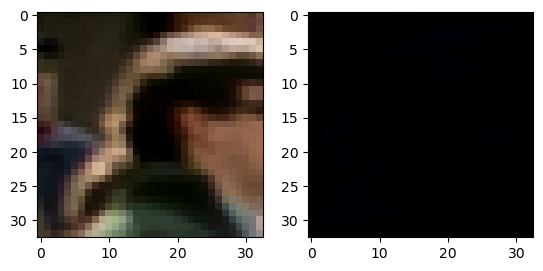

In [14]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(image_helper.tensor_as_image(img.cpu()))
plt.subplot(1, 2, 2)
plt.imshow(image_helper.tensor_as_image(img_out.squeeze().cpu()))
plt.show()

# Criando o *Optmizer* e a *loss function* (MSE)

In [15]:
# otimizacao: Mudar o otimizador para Adam ou RMSProp
#           : Usar momentum = 0.9
#           : Usar learning maior: 1e-4?
#           : Usar learning rate decay

# 3.3 Training
# The loss is minimized using stochastic gradient descent with the standard backpropagation
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# we use Mean Squared Error (MSE) as the loss function:
loss_fn = nn.MSELoss()
loss_fn.to(device)

MSELoss()

# Exemplos de imagem de baixa e alta resolução do dataset de treino

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> torch.Size([3686, 3, 33, 33]) torch.float32 tensor(-0.2122) tensor(1.2791)
<class 'torch.Tensor'> torch.Size([3686, 3, 33, 33]) torch.float32 tensor(0.) tensor(1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> torch.Size([3686, 3, 33, 33]) torch.float32 tensor(-0.2131) tensor(1.2308)
<class 'torch.Tensor'> torch.Size([3686, 3, 33, 33]) torch.float32 tensor(0.) tensor(1.)


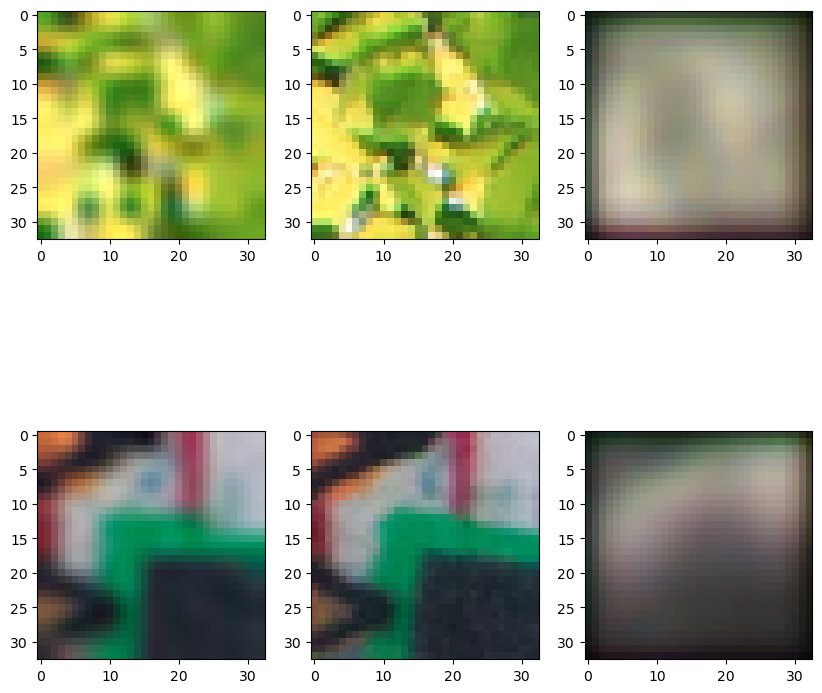

In [31]:
# example of training image
num_samples = 2
fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))
for i, (X, y) in enumerate(train_dataloader):
    with torch.no_grad():
        z = model.forward(X.to(device))
    print(type(X), X.shape, X.dtype, X.min(), X.max())
    print(type(y), y.shape, y.dtype, y.min(), y.max())
    axes[i, 0].imshow(image_helper.tensor_as_image(X[0]))
    axes[i, 1].imshow(image_helper.tensor_as_image(y[0]))
    axes[i, 2].imshow(image_helper.tensor_as_image(z[0].cpu()))
    # axes[i, 0].set_axis_off()
    if i == num_samples - 1:
        break
plt.show()

# Carregando o modelo

## Carregando a última *epoch* executada

In [17]:
# most_recent_epoch, model_load_path_name = load_model_helper.get_most_recent_epoch(directory = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/models')

# print("Most recent epoch:", most_recent_epoch)
# print("Model load path name:", model_load_path_name)

model_load_path_name = ''

In [18]:
# model = load_model_helper.load_state_dict(model, model_load_path_name)

# **Treinamento** 

## Execução das *epochs*
- Execução dos loops de treinamento e validação, e também salvamentos dos dados

In [19]:
# starting_epoch = load_model_helper.get_epoch_number_from_path(model_load_path_name)
# if starting_epoch is not None:
#   starting_epoch = starting_epoch + 1 # add 1 because we are starting after the epoch we left of

# print('starting_epoch =', starting_epoch)
starting_epoch = 0

In [20]:
%%time
train_loss = 0
validation_loss =0
epochs = 300

######
epoch_array = []
time_array = []
lr_array = []
######

# melhor usar lista e depois converter para array
train_loss_array = list()
validation_loss_array = list()
for index, t in enumerate(range(epochs)):
    current_epoch = load_model_helper.get_current_epoch(index, t, starting_epoch)
    
    print(f"\nepoch {current_epoch}\n-------------------------------")

    start_time = time.time()  # Start timing the epoch

    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    validation_loss = validation_loop(validation_dataloader, model, loss_fn)
    
    train_loss_array.append(train_loss)
    validation_loss_array.append(validation_loss)

    elapsed_time = time.time() - start_time  # Calculate elapsed time for the epoch
    
    ######
    epoch_array.append(current_epoch)
    time_array.append(elapsed_time)
    lr_array.append(optimizer.param_groups[0]['lr'])
    ######
    
    # updating learning rate
    if current_epoch % 10 == 0 and current_epoch > 0:
        optimizer.param_groups[0]['lr'] /= 2

    if not EXPERIMENTAL_MODE:
      df_path = '/content/gdrive/My Drive/TCC/code/models/SRCNN/testing/train_session_testing/SRCNN_train_vs_validation_loss.csv'
      save_model_helper.save_df(df_path, train_loss, validation_loss, current_epoch, elapsed_time)
      save_model_helper.save_epoch(current_epoch, train_loss, validation_loss)
    
print("Done!")


epoch 0
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:14<00:00,  5.62s/it]


Training Error: 
 Avg loss: 0.244926 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.78s/it]


Validation Error: 
 Avg loss: 0.198793 


epoch 1
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:57<00:00,  4.88s/it]


Training Error: 
 Avg loss: 0.154603 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:12<00:00,  2.16s/it]


Validation Error: 
 Avg loss: 0.108885 


epoch 2
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:48<00:00,  4.52s/it]


Training Error: 
 Avg loss: 0.077622 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.18s/it]


Validation Error: 
 Avg loss: 0.052788 


epoch 3
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:47<00:00,  4.48s/it]


Training Error: 
 Avg loss: 0.043980 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.63s/it]


Validation Error: 
 Avg loss: 0.038992 


epoch 4
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.69s/it]


Training Error: 
 Avg loss: 0.037935 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.47s/it]


Validation Error: 
 Avg loss: 0.037183 


epoch 5
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.75s/it]


Training Error: 
 Avg loss: 0.036781 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.84s/it]


Validation Error: 
 Avg loss: 0.036836 


epoch 6
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.82s/it]


Training Error: 
 Avg loss: 0.036613 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]


Validation Error: 
 Avg loss: 0.036619 


epoch 7
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.85s/it]


Training Error: 
 Avg loss: 0.036416 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.68s/it]


Validation Error: 
 Avg loss: 0.036410 


epoch 8
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.84s/it]


Training Error: 
 Avg loss: 0.036470 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.57s/it]


Validation Error: 
 Avg loss: 0.036209 


epoch 9
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:06<00:00,  5.25s/it]


Training Error: 
 Avg loss: 0.036310 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.69s/it]


Validation Error: 
 Avg loss: 0.036010 


epoch 10
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.74s/it]


Training Error: 
 Avg loss: 0.035684 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.53s/it]


Validation Error: 
 Avg loss: 0.035816 


epoch 11
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.76s/it]


Training Error: 
 Avg loss: 0.035840 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


Validation Error: 
 Avg loss: 0.035717 


epoch 12
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.74s/it]


Training Error: 
 Avg loss: 0.035429 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.58s/it]


Validation Error: 
 Avg loss: 0.035622 


epoch 13
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.79s/it]


Training Error: 
 Avg loss: 0.035510 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.66s/it]


Validation Error: 
 Avg loss: 0.035525 


epoch 14
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.63s/it]


Training Error: 
 Avg loss: 0.035379 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.97s/it]


Validation Error: 
 Avg loss: 0.035429 


epoch 15
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.76s/it]


Training Error: 
 Avg loss: 0.035585 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.56s/it]


Validation Error: 
 Avg loss: 0.035332 


epoch 16
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.81s/it]


Training Error: 
 Avg loss: 0.035394 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.69s/it]


Validation Error: 
 Avg loss: 0.035235 


epoch 17
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.70s/it]


Training Error: 
 Avg loss: 0.035350 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.88s/it]


Validation Error: 
 Avg loss: 0.035139 


epoch 18
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.82s/it]


Training Error: 
 Avg loss: 0.034925 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.63s/it]


Validation Error: 
 Avg loss: 0.035045 


epoch 19
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.66s/it]


Training Error: 
 Avg loss: 0.034936 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.47s/it]


Validation Error: 
 Avg loss: 0.034950 


epoch 20
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.73s/it]


Training Error: 
 Avg loss: 0.035299 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.85s/it]


Validation Error: 
 Avg loss: 0.034854 


epoch 21
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.83s/it]


Training Error: 
 Avg loss: 0.034661 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.57s/it]


Validation Error: 
 Avg loss: 0.034807 


epoch 22
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.70s/it]


Training Error: 
 Avg loss: 0.034860 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.81s/it]


Validation Error: 
 Avg loss: 0.034760 


epoch 23
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.73s/it]


Training Error: 
 Avg loss: 0.034828 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.69s/it]


Validation Error: 
 Avg loss: 0.034713 


epoch 24
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.69s/it]


Training Error: 
 Avg loss: 0.034355 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.60s/it]


Validation Error: 
 Avg loss: 0.034667 


epoch 25
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:50<00:00,  4.62s/it]


Training Error: 
 Avg loss: 0.034886 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.85s/it]


Validation Error: 
 Avg loss: 0.034620 


epoch 26
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.79s/it]


Training Error: 
 Avg loss: 0.035087 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.78s/it]


Validation Error: 
 Avg loss: 0.034573 


epoch 27
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.84s/it]


Training Error: 
 Avg loss: 0.034769 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.94s/it]


Validation Error: 
 Avg loss: 0.034526 


epoch 28
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.86s/it]


Training Error: 
 Avg loss: 0.034822 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.74s/it]


Validation Error: 
 Avg loss: 0.034479 


epoch 29
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.83s/it]


Training Error: 
 Avg loss: 0.034302 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.63s/it]


Validation Error: 
 Avg loss: 0.034433 


epoch 30
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.82s/it]


Training Error: 
 Avg loss: 0.034540 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.82s/it]


Validation Error: 
 Avg loss: 0.034387 


epoch 31
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.82s/it]


Training Error: 
 Avg loss: 0.034456 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.72s/it]


Validation Error: 
 Avg loss: 0.034364 


epoch 32
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.69s/it]


Training Error: 
 Avg loss: 0.034234 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.77s/it]


Validation Error: 
 Avg loss: 0.034342 


epoch 33
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.83s/it]


Training Error: 
 Avg loss: 0.034235 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.86s/it]


Validation Error: 
 Avg loss: 0.034319 


epoch 34
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.79s/it]


Training Error: 
 Avg loss: 0.034404 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.67s/it]


Validation Error: 
 Avg loss: 0.034296 


epoch 35
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.83s/it]


Training Error: 
 Avg loss: 0.033965 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.75s/it]


Validation Error: 
 Avg loss: 0.034274 


epoch 36
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.87s/it]


Training Error: 
 Avg loss: 0.034565 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.58s/it]


Validation Error: 
 Avg loss: 0.034251 


epoch 37
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.84s/it]


Training Error: 
 Avg loss: 0.034551 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.65s/it]


Validation Error: 
 Avg loss: 0.034228 


epoch 38
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.82s/it]


Training Error: 
 Avg loss: 0.034292 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.57s/it]


Validation Error: 
 Avg loss: 0.034206 


epoch 39
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:00<00:00,  5.00s/it]


Training Error: 
 Avg loss: 0.034237 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


Validation Error: 
 Avg loss: 0.034183 


epoch 40
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.79s/it]


Training Error: 
 Avg loss: 0.033694 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.51s/it]


Validation Error: 
 Avg loss: 0.034162 


epoch 41
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.65s/it]


Training Error: 
 Avg loss: 0.033811 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.56s/it]


Validation Error: 
 Avg loss: 0.034151 


epoch 42
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.63s/it]


Training Error: 
 Avg loss: 0.033695 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]


Validation Error: 
 Avg loss: 0.034140 


epoch 43
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.63s/it]


Training Error: 
 Avg loss: 0.033994 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


Validation Error: 
 Avg loss: 0.034129 


epoch 44
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:50<00:00,  4.62s/it]


Training Error: 
 Avg loss: 0.034537 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.82s/it]


Validation Error: 
 Avg loss: 0.034118 


epoch 45
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:50<00:00,  4.61s/it]


Training Error: 
 Avg loss: 0.034233 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.43s/it]


Validation Error: 
 Avg loss: 0.034106 


epoch 46
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.65s/it]


Training Error: 
 Avg loss: 0.034012 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.70s/it]


Validation Error: 
 Avg loss: 0.034096 


epoch 47
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.68s/it]


Training Error: 
 Avg loss: 0.034076 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


Validation Error: 
 Avg loss: 0.034085 


epoch 48
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.76s/it]


Training Error: 
 Avg loss: 0.034352 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.64s/it]


Validation Error: 
 Avg loss: 0.034073 


epoch 49
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.87s/it]


Training Error: 
 Avg loss: 0.034324 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.53s/it]


Validation Error: 
 Avg loss: 0.034062 


epoch 50
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:57<00:00,  4.91s/it]


Training Error: 
 Avg loss: 0.034079 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.80s/it]


Validation Error: 
 Avg loss: 0.034051 


epoch 51
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.86s/it]


Training Error: 
 Avg loss: 0.034345 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.29s/it]


Validation Error: 
 Avg loss: 0.034046 


epoch 52
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.73s/it]


Training Error: 
 Avg loss: 0.033848 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.52s/it]


Validation Error: 
 Avg loss: 0.034041 


epoch 53
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.69s/it]


Training Error: 
 Avg loss: 0.033603 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.39s/it]


Validation Error: 
 Avg loss: 0.034035 


epoch 54
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:48<00:00,  4.53s/it]


Training Error: 
 Avg loss: 0.034068 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.54s/it]


Validation Error: 
 Avg loss: 0.034030 


epoch 55
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.68s/it]


Training Error: 
 Avg loss: 0.034283 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.78s/it]


Validation Error: 
 Avg loss: 0.034024 


epoch 56
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.78s/it]


Training Error: 
 Avg loss: 0.034193 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.42s/it]


Validation Error: 
 Avg loss: 0.034019 


epoch 57
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.79s/it]


Training Error: 
 Avg loss: 0.034068 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.52s/it]


Validation Error: 
 Avg loss: 0.034013 


epoch 58
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.72s/it]


Training Error: 
 Avg loss: 0.033816 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.53s/it]


Validation Error: 
 Avg loss: 0.034008 


epoch 59
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.80s/it]


Training Error: 
 Avg loss: 0.034015 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.41s/it]


Validation Error: 
 Avg loss: 0.034002 


epoch 60
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.72s/it]


Training Error: 
 Avg loss: 0.034446 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]


Validation Error: 
 Avg loss: 0.033997 


epoch 61
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:50<00:00,  4.59s/it]


Training Error: 
 Avg loss: 0.034160 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.62s/it]


Validation Error: 
 Avg loss: 0.033994 


epoch 62
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.67s/it]


Training Error: 
 Avg loss: 0.034426 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.65s/it]


Validation Error: 
 Avg loss: 0.033991 


epoch 63
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.81s/it]


Training Error: 
 Avg loss: 0.033981 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.55s/it]


Validation Error: 
 Avg loss: 0.033989 


epoch 64
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.74s/it]


Training Error: 
 Avg loss: 0.033893 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.76s/it]


Validation Error: 
 Avg loss: 0.033986 


epoch 65
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.78s/it]


Training Error: 
 Avg loss: 0.034054 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.70s/it]


Validation Error: 
 Avg loss: 0.033983 


epoch 66
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.79s/it]


Training Error: 
 Avg loss: 0.033797 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.68s/it]


Validation Error: 
 Avg loss: 0.033981 


epoch 67
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:57<00:00,  4.88s/it]


Training Error: 
 Avg loss: 0.034017 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.73s/it]


Validation Error: 
 Avg loss: 0.033978 


epoch 68
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.87s/it]


Training Error: 
 Avg loss: 0.034097 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.78s/it]


Validation Error: 
 Avg loss: 0.033975 


epoch 69
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.82s/it]


Training Error: 
 Avg loss: 0.034214 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.87s/it]


Validation Error: 
 Avg loss: 0.033972 


epoch 70
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.85s/it]


Training Error: 
 Avg loss: 0.033858 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.53s/it]


Validation Error: 
 Avg loss: 0.033970 


epoch 71
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.77s/it]


Training Error: 
 Avg loss: 0.033644 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


Validation Error: 
 Avg loss: 0.033968 


epoch 72
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:59<00:00,  4.97s/it]


Training Error: 
 Avg loss: 0.034061 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.49s/it]


Validation Error: 
 Avg loss: 0.033967 


epoch 73
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.78s/it]


Training Error: 
 Avg loss: 0.034180 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.55s/it]


Validation Error: 
 Avg loss: 0.033966 


epoch 74
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:59<00:00,  4.96s/it]


Training Error: 
 Avg loss: 0.034051 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.47s/it]


Validation Error: 
 Avg loss: 0.033964 


epoch 75
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.71s/it]


Training Error: 
 Avg loss: 0.034033 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.42s/it]


Validation Error: 
 Avg loss: 0.033963 


epoch 76
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.81s/it]


Training Error: 
 Avg loss: 0.034129 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.54s/it]


Validation Error: 
 Avg loss: 0.033962 


epoch 77
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.71s/it]


Training Error: 
 Avg loss: 0.033990 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.69s/it]


Validation Error: 
 Avg loss: 0.033960 


epoch 78
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.69s/it]


Training Error: 
 Avg loss: 0.034054 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.68s/it]


Validation Error: 
 Avg loss: 0.033959 


epoch 79
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:50<00:00,  4.59s/it]


Training Error: 
 Avg loss: 0.033846 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.71s/it]


Validation Error: 
 Avg loss: 0.033958 


epoch 80
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.63s/it]


Training Error: 
 Avg loss: 0.034104 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.56s/it]


Validation Error: 
 Avg loss: 0.033956 


epoch 81
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.69s/it]


Training Error: 
 Avg loss: 0.033873 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.66s/it]


Validation Error: 
 Avg loss: 0.033956 


epoch 82
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.67s/it]


Training Error: 
 Avg loss: 0.034132 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.70s/it]


Validation Error: 
 Avg loss: 0.033955 


epoch 83
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.71s/it]


Training Error: 
 Avg loss: 0.033941 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.54s/it]


Validation Error: 
 Avg loss: 0.033954 


epoch 84
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:50<00:00,  4.62s/it]


Training Error: 
 Avg loss: 0.034175 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.83s/it]


Validation Error: 
 Avg loss: 0.033954 


epoch 85
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.76s/it]


Training Error: 
 Avg loss: 0.034055 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.62s/it]


Validation Error: 
 Avg loss: 0.033953 


epoch 86
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.73s/it]


Training Error: 
 Avg loss: 0.034393 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.75s/it]


Validation Error: 
 Avg loss: 0.033952 


epoch 87
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.87s/it]


Training Error: 
 Avg loss: 0.033959 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.79s/it]


Validation Error: 
 Avg loss: 0.033952 


epoch 88
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.70s/it]


Training Error: 
 Avg loss: 0.033901 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.49s/it]


Validation Error: 
 Avg loss: 0.033951 


epoch 89
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.65s/it]


Training Error: 
 Avg loss: 0.034125 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.61s/it]


Validation Error: 
 Avg loss: 0.033950 


epoch 90
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.72s/it]


Training Error: 
 Avg loss: 0.034123 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.85s/it]


Validation Error: 
 Avg loss: 0.033950 


epoch 91
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.68s/it]


Training Error: 
 Avg loss: 0.034202 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.62s/it]


Validation Error: 
 Avg loss: 0.033949 


epoch 92
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.83s/it]


Training Error: 
 Avg loss: 0.034388 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.69s/it]


Validation Error: 
 Avg loss: 0.033949 


epoch 93
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:57<00:00,  4.88s/it]


Training Error: 
 Avg loss: 0.033863 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]


Validation Error: 
 Avg loss: 0.033949 


epoch 94
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.74s/it]


Training Error: 
 Avg loss: 0.033628 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.49s/it]


Validation Error: 
 Avg loss: 0.033949 


epoch 95
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.67s/it]


Training Error: 
 Avg loss: 0.033880 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.60s/it]


Validation Error: 
 Avg loss: 0.033948 


epoch 96
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.73s/it]


Training Error: 
 Avg loss: 0.034084 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.23s/it]


Validation Error: 
 Avg loss: 0.033948 


epoch 97
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.70s/it]


Training Error: 
 Avg loss: 0.034148 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.53s/it]


Validation Error: 
 Avg loss: 0.033948 


epoch 98
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.79s/it]


Training Error: 
 Avg loss: 0.033769 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.51s/it]


Validation Error: 
 Avg loss: 0.033947 


epoch 99
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.73s/it]


Training Error: 
 Avg loss: 0.033949 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]


Validation Error: 
 Avg loss: 0.033947 


epoch 100
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.77s/it]


Training Error: 
 Avg loss: 0.034319 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.62s/it]


Validation Error: 
 Avg loss: 0.033947 


epoch 101
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.65s/it]


Training Error: 
 Avg loss: 0.033890 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.83s/it]


Validation Error: 
 Avg loss: 0.033947 


epoch 102
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.64s/it]


Training Error: 
 Avg loss: 0.033830 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


Validation Error: 
 Avg loss: 0.033946 


epoch 103
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.71s/it]


Training Error: 
 Avg loss: 0.033974 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.71s/it]


Validation Error: 
 Avg loss: 0.033946 


epoch 104
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.80s/it]


Training Error: 
 Avg loss: 0.034207 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.58s/it]


Validation Error: 
 Avg loss: 0.033946 


epoch 105
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.74s/it]


Training Error: 
 Avg loss: 0.033793 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.54s/it]


Validation Error: 
 Avg loss: 0.033946 


epoch 106
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.84s/it]


Training Error: 
 Avg loss: 0.033957 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.50s/it]


Validation Error: 
 Avg loss: 0.033946 


epoch 107
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.83s/it]


Training Error: 
 Avg loss: 0.034021 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.87s/it]


Validation Error: 
 Avg loss: 0.033946 


epoch 108
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.81s/it]


Training Error: 
 Avg loss: 0.033808 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.59s/it]


Validation Error: 
 Avg loss: 0.033946 


epoch 109
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.83s/it]


Training Error: 
 Avg loss: 0.033558 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.56s/it]


Validation Error: 
 Avg loss: 0.033946 


epoch 110
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.83s/it]


Training Error: 
 Avg loss: 0.033736 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.48s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 111
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.65s/it]


Training Error: 
 Avg loss: 0.033961 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.71s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 112
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.72s/it]


Training Error: 
 Avg loss: 0.034439 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.80s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 113
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:57<00:00,  4.89s/it]


Training Error: 
 Avg loss: 0.033505 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.55s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 114
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.73s/it]


Training Error: 
 Avg loss: 0.033904 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.80s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 115
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.81s/it]


Training Error: 
 Avg loss: 0.033614 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.71s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 116
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:58<00:00,  4.92s/it]


Training Error: 
 Avg loss: 0.034591 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.94s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 117
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.83s/it]


Training Error: 
 Avg loss: 0.034123 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 118
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.75s/it]


Training Error: 
 Avg loss: 0.033825 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.51s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 119
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.76s/it]


Training Error: 
 Avg loss: 0.033888 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.83s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 120
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.81s/it]


Training Error: 
 Avg loss: 0.033819 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.41s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 121
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [02:00<00:00,  5.00s/it]


Training Error: 
 Avg loss: 0.034111 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.74s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 122
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:59<00:00,  4.98s/it]


Training Error: 
 Avg loss: 0.033991 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.66s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 123
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.75s/it]


Training Error: 
 Avg loss: 0.034002 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.68s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 124
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:55<00:00,  4.80s/it]


Training Error: 
 Avg loss: 0.033894 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.58s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 125
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.72s/it]


Training Error: 
 Avg loss: 0.034505 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.47s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 126
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.69s/it]


Training Error: 
 Avg loss: 0.034255 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.55s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 127
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.67s/it]


Training Error: 
 Avg loss: 0.033872 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.49s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 128
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:50<00:00,  4.59s/it]


Training Error: 
 Avg loss: 0.033787 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.65s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 129
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.64s/it]


Training Error: 
 Avg loss: 0.033721 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:19<00:00,  3.17s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 130
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.67s/it]


Training Error: 
 Avg loss: 0.033899 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.46s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 131
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:51<00:00,  4.64s/it]


Training Error: 
 Avg loss: 0.034244 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:17<00:00,  2.97s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 132
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.77s/it]


Training Error: 
 Avg loss: 0.033901 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.50s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 133
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:52<00:00,  4.69s/it]


Training Error: 
 Avg loss: 0.034030 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.60s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 134
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.78s/it]


Training Error: 
 Avg loss: 0.034125 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:15<00:00,  2.60s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 135
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.73s/it]


Training Error: 
 Avg loss: 0.033782 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.76s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 136
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.79s/it]


Training Error: 
 Avg loss: 0.034504 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.69s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 137
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.76s/it]


Training Error: 
 Avg loss: 0.033682 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.74s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 138
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:56<00:00,  4.84s/it]


Training Error: 
 Avg loss: 0.033894 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.70s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 139
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:57<00:00,  4.91s/it]


Training Error: 
 Avg loss: 0.034091 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.70s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 140
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.72s/it]


Training Error: 
 Avg loss: 0.033856 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:16<00:00,  2.74s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 141
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.76s/it]


Training Error: 
 Avg loss: 0.034132 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.34s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 142
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:53<00:00,  4.73s/it]


Training Error: 
 Avg loss: 0.033899 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:13<00:00,  2.32s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 143
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:54<00:00,  4.76s/it]


Training Error: 
 Avg loss: 0.034100 



100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:14<00:00,  2.34s/it]


Validation Error: 
 Avg loss: 0.033945 


epoch 144
-------------------------------
Training on 84800 samples...
Batch size: 3686
Number of batches: 24


  0%|                                                                                           | 0/24 [00:18<?, ?it/s]


KeyboardInterrupt: 

# Train x Validation Loss

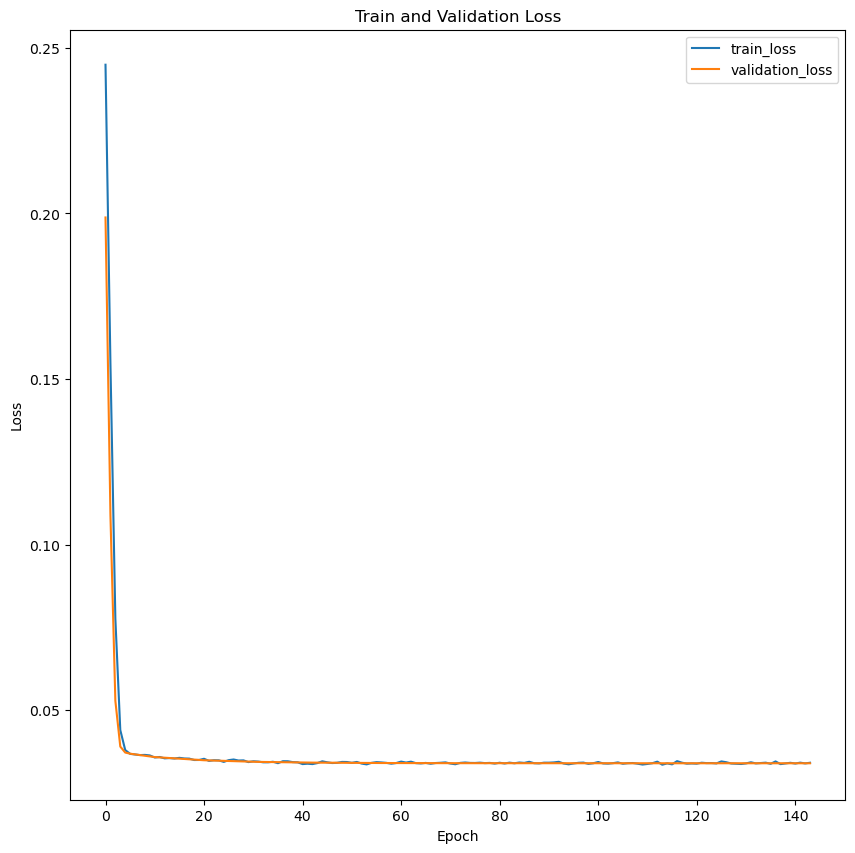

In [26]:
train_loss_array = np.array(train_loss_array)
validation_loss_array = np.array(validation_loss_array)

plt.figure(figsize=(10, 10))
plt.plot(range(len(train_loss_array)), train_loss_array, label='train_loss')
plt.plot(range(len(validation_loss_array)), validation_loss_array, label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

In [27]:
df = pd.DataFrame({'Train Loss': train_loss_array, 'Validation Loss': validation_loss_array, 'epoch': epoch_array, 'learning rate': lr_array, 'epoch_duration [s]': time_array})
df.head()

,Train Loss,Validation Loss,epoch,learning rate,epoch_duration [s]
0,0.244926,0.198793,0,0.001,179.013537
1,0.154603,0.108885,1,0.001,157.911178
2,0.077622,0.052788,2,0.001,153.088942
3,0.043980,0.038992,3,0.001,156.622810
4,0.037935,0.037183,4,0.001,152.401052


In [28]:
df

,Train Loss,Validation Loss,epoch,learning rate,epoch_duration [s]
0,0.244926,0.198793,0,1.000000e-03,179.013537
1,0.154603,0.108885,1,1.000000e-03,157.911178
2,0.077622,0.052788,2,1.000000e-03,153.088942
3,0.043980,0.038992,3,1.000000e-03,156.622810
4,0.037935,0.037183,4,1.000000e-03,152.401052
...,...,...,...,...,...
139,0.034091,0.033945,139,1.220703e-07,164.507391
140,0.033856,0.033945,140,1.220703e-07,160.357188
141,0.034132,0.033945,141,6.103516e-08,161.122332
142,0.033899,0.033945,142,6.103516e-08,162.500038


# Tesntando o modelo em uma imagem

C:\Users\Pedro\AppData\Local\Temp\ipykernel_10584\1583506645.py:5: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((128, 128), interpolation=Image.LINEAR),
C:\Users\Pedro\AppData\Local\Temp\ipykernel_10584\1583506645.py:7: DeprecationWarning: LINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use BILINEAR or Resampling.BILINEAR instead.
  transforms.Resize((256, 256), interpolation=Image.LINEAR)
C:\Users\Pedro\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PI

torch.Size([3, 256, 256])
246


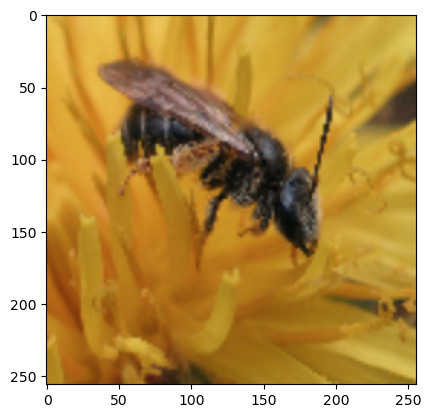

In [29]:
new_image = Image.open(f"{DATASET_ROOT}/Flickr2K/000797.png")
transform = transforms.Compose([
    transforms.ToTensor(),
    # resize image to 33x33 and downsample by BICUBIC interpolation
    transforms.Resize((128, 128), interpolation=Image.LINEAR),
    # resize image to 256x256
    transforms.Resize((256, 256), interpolation=Image.LINEAR)
])


new_image_lr = transform(new_image)
print(new_image_lr.shape)
print(np.array(new_image).max())
image_helper.show_tensor_as_image(new_image_lr) # mudar pro arquivo novo


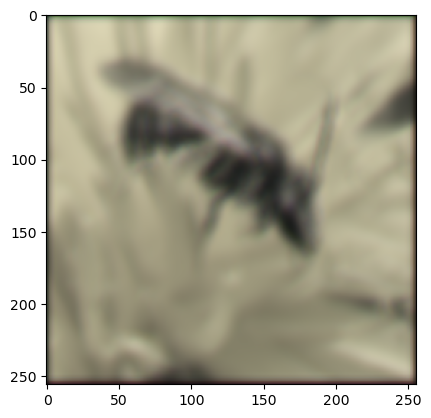

In [41]:
import matplotlib.pyplot as plt

plt.figure()
new_image_sr = model(new_image_lr.to(device))
new_image_sr_np = new_image_sr.cpu().detach().numpy()
# new_img = torch.mul(new_image_sr, 3)
plt.imshow(new_image_sr_np.transpose((1, 2, 0)))
plt.show()

In [39]:
model(torch.randn([3, 33, 33]).to(device))

tensor([[[0.0981, 0.1105, 0.0447,  ..., 0.0805, 0.0591, 0.0436],
         [0.0648, 0.0792, 0.1402,  ..., 0.0568, 0.0728, 0.0724],
         [0.0621, 0.1908, 0.1622,  ..., 0.1159, 0.2083, 0.1299],
         ...,
         [0.0661, 0.1143, 0.2572,  ..., 0.3018, 0.2203, 0.1844],
         [0.1027, 0.0939, 0.1790,  ..., 0.2652, 0.1489, 0.1524],
         [0.0849, 0.1182, 0.1446,  ..., 0.2124, 0.1280, 0.1250]],

        [[0.0943, 0.0969, 0.0865,  ..., 0.1200, 0.1191, 0.0780],
         [0.0874, 0.1812, 0.1910,  ..., 0.1560, 0.1410, 0.0869],
         [0.1459, 0.2135, 0.2133,  ..., 0.1947, 0.1855, 0.1347],
         ...,
         [0.1222, 0.1376, 0.1164,  ..., 0.0969, 0.1607, 0.1079],
         [0.1036, 0.0600, 0.2130,  ..., 0.0627, 0.0862, 0.0887],
         [0.0402, 0.0487, 0.0651,  ..., 0.1037, 0.0393, 0.0859]],

        [[0.0201, 0.0723, 0.0106,  ..., 0.0748, 0.0065, 0.0018],
         [0.1123, 0.1802, 0.0770,  ..., 0.1518, 0.0767, 0.0323],
         [0.0602, 0.1670, 0.1897,  ..., 0.1196, 0.0880, 0.